In [24]:

def trainRBF(xin, yin, p, lambda_reg):

    import numpy as np
    from sklearn.cluster import KMeans
    import pandas as pd

    # Função Radial Gaussiana
    def pdfnvar(x, m, K, n):
        if(n == 1):
            r = np.sqrt(int(K))
            px = (1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * ((x-m)/(r))**2)
        else:
            px = ((1/np.sqrt((2*np.pi)**n * (np.linalg.det(K))))) * np.exp(-0.5*((x-m) @ (np.linalg.inv(K) @ np.transpose(x-m))))
        return px

    nSamples = xin.shape[0]     # Numero de amostras.
    nDimension = xin.shape[1]   # Dimensao de entrada.  

    xin = np.asmatrix(xin)  # garante que xin seja matriz
    yin = np.asmatrix(yin)  # garante que yin seja matriz

    #clusteriza os dados de entrada por meio do algorítmo K-médias
    xclust = KMeans(n_clusters=p).fit(xin)

    # Armazena vetores de centros das funções
    m = np.asmatrix(xclust.cluster_centers_)
    covlist = []
    
    # Estima matrizes de covarância para todos os centros
    for i in range(p):
        ici = np.where(xclust.labels_ == i)
        xci = xin[ici,]
        if nDimension == 1:
            covi = np.var(xci)
        else:
            covi = np.cov(xci[0], rowvar=False)
        covlist.append(covi)

    H =  np.zeros((nSamples, p))

    #calcula matriz H
    for j in range(nSamples):
        for i in range(p):
            mi = m[i,]
            covi = np.transpose(covlist[i]) + 0.001*np.identity(nDimension)
            aux = pdfnvar(xin[j,], mi, covi, nDimension)
            aux = np.asarray(aux)
            H[j][i] = aux[0]

    Haug = pd.DataFrame(H)
    Haug.insert(H.shape[1], H.shape[1], 1)
    Haug.to_numpy()

    A = (Haug.T @ Haug) + lambda_reg * np.identity(Haug.shape[1])  # Matriz de Variância

    P = (np.identity(nSamples) - Haug @ (np.linalg.inv(A) @ Haug.T)) # Matriz de Projeção

    W = (np.linalg.inv(A) @ Haug.T) @ yin.T    # Calculo dos pesos

    return [m, covlist, W, H, A, P]



# Calcula a saída da rede RBF
def YRBF(xin, modRBF):

    import numpy as np
    from sklearn.cluster import KMeans
    import pandas as pd

    # Função Radial Gaussiana
    def pdfnvar(x, m, K, n):
        if(n == 1):
            r = np.sqrt(int(K))
            px = (1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * ((x-m)/(r))**2)
        else:
            px = ((1/np.sqrt((2*np.pi)**n * (np.linalg.det(K))))) * np.exp(-0.5*((x-m) @ (np.linalg.inv(K) @ np.transpose(x-m))))
        return px

    nSamples = xin.shape[0]     # Numero de amostras.
    nDimension = xin.shape[1]   # Dimensao de entrada.  

    m = modRBF[0]
    covlist = modRBF[1]
    p = len(covlist)            # Numero de funções radiais
    W = modRBF[2]

    H = np.zeros((nSamples, p))

    #calcula matriz H
    for j in range(nSamples):
        for i in range(p):
            mi = m[i,]
            covi = np.transpose(covlist[i]) + 0.001*np.identity(nDimension)
            aux = pdfnvar(xin[j,], mi, covi, nDimension)
            aux = np.asarray(aux)
            H[j][i] = aux[0]
    
    Haug = pd.DataFrame(H)
    Haug.insert(H.shape[1], H.shape[1], 1)
    Haug.to_numpy()

    Yhat = Haug @ W

    return Yhat

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


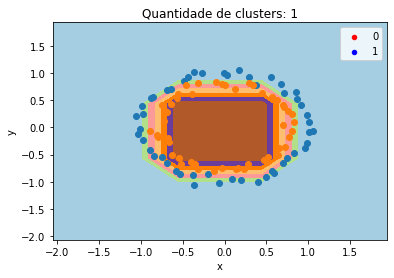

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


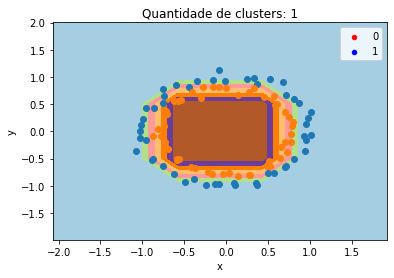

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


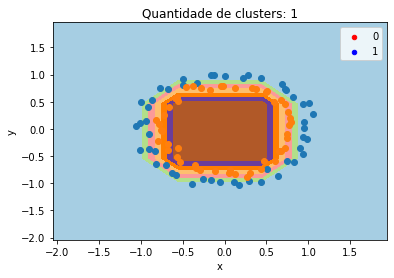

In [32]:
from sklearn.datasets import make_circles, make_moons, make_blobs
import matplotlib.pyplot as plt
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
import pandas as pd

def plotContour(format, nClusters, lambda_reg):
    if(format == 1):
        X, y = make_circles(n_samples=100, noise=0.05)
    elif(format == 2):
        X, y = make_moons(n_samples=100, noise=0.05)
    # scatter plot, dots colored by class value

    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = arange(min1, max1, 0.5)
    x2grid = arange(min2, max2, 0.5)
    # create all of the lines and rows of the grid
    xx, yy = meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = hstack((r1,r2))

    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

    retlist = trainRBF(X[:,:2], y, nClusters, lambda_reg)

    m = retlist[0]
    covlist = retlist[1]
    W = retlist[2]
    H = retlist[3]
    
    #plotting contours
    # Make prediction from training process
    yhat = YRBF(grid, retlist)
    yhat = (yhat > 0.5).astype(int)
    yhat = pd.DataFrame(yhat).to_numpy()

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    if(nClusters == 1):
        plt.title('Quantidade de clusters: 1')
    if(nClusters == 5):
        plt.title('Quantidade de clusters: 5')
    elif(nClusters == 10):
        plt.title('Quantidade de clusters: 10')
    elif(nClusters == 30):
        plt.title('Quantidade de clusters: 30')
    plt.show()

plotContour(1,1,1)
plotContour(1,1,0.5)
plotContour(1,1,0.1)
# plotContour(1,5)
# plotContour(1,10)
# plotContour(1,30)
# plotContour(2,5)
# plotContour(2,10)
# plotContour(2,30)



In [30]:
import numpy as np
x = np.asmatrix(np.arange(0, 2*np.pi, 0.3*np.pi))
n = len(x)
y = np.asmatrix(np.sin(x))

m1 = 0.5*np.pi
m2 = 3*np.pi/2
r1 = 0.6
r2 = 0.6
p = 2

retlist = trainRBF(x, y.T, 1, r1)

m = retlist[0]
covlist = retlist[1]
W = retlist[2]
H = retlist[3]
A = retlist[4]
P = retlist[5]

print(H[0])


Je = y.T @ (P @ P) @ y
Jew = (y - yhat).T @ (y - yhat)

Jw = y.T @ (P - P @ P) @ y
Jww = w.T @ L @ w

J = y.T @ P @ y
Jsum = Jew + Jww



[298565.37417297]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


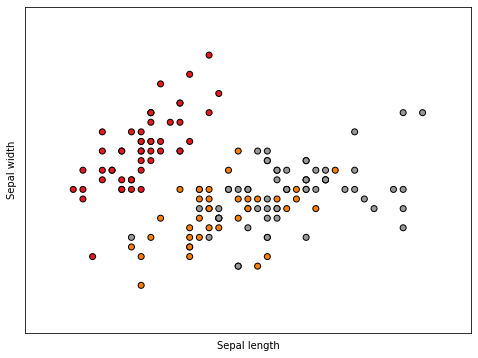

Jew:  5.8972866702229325
Jww:  0.293782396668571


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [81]:
from sklearn import datasets

# import
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

xc1 = iris.data[:49,]
xc2 = iris.data[50:99,]

y1 = iris.target[:49,]
y2 = iris.target[50:99,]

# Plotting

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

# Selecionando 30 valores para treinamento
xcTrain1 = xc1[:29,]
xcTrain2 = xc2[:29,]
yTrain1 = y1[:29,]
yTrain2= y2[:29,]
xcTest1 = xc1[30:49,]
xcTest2 = xc2[30:49,]
yTest1 = y1[30:49,]
yTest2 = y2[30:49,]

# Treinamento
xcTrain = np.concatenate((xcTrain1, xcTrain2), axis=0)
yTrain = np.concatenate((yTrain1, yTrain2), axis=0)

# Teste
xcTest = np.concatenate((xcTest1, xcTest2), axis=0)
yTest = np.concatenate((yTest1, yTest2), axis=0)

retlist = trainRBF(xcTrain, yTrain, 6, 1)

m = retlist[0]
covlist = retlist[1]
W = retlist[2]
H = retlist[3]
A = retlist[4]
P = retlist[5]

Yhat = YRBF(xcTest, retlist)

L = 1 * np.identity(H.shape[1]+1)
Yhat = np.array(Yhat)
yTest = np.array(yTest)

# Je = y.T @ (P @ P) @ y
Jew = (yTest - Yhat[:,0]).T @ (yTest - Yhat[:,0])
print("Jew: ", Jew)

# Jw = y.T @ (P - P @ P) @ y
Jww = W.T @ L @ W
print("Jww: ", Jww.values[0,0])

# J = y.T @ P @ y
Jsum = Jew + Jww

# print("Inferências")
# print("Yhat: \n", Yhat)